In [1]:
import pandas as pd
from pybatfish.client.session import Session
from pybatfish.datamodel import *
from pybatfish.datamodel.answer import *
from pybatfish.datamodel.flow import *

# Set up a connection to the batfish session
bf = Session(host="localhost")

# Assign a friendly name to your network and snapshot
NETWORK_NAME = "bics_network"
SNAPSHOT_NAME = "simple_snapshot"

SNAPSHOT_PATH = "scenarios/bics/ospf/"

# Now create the network and initialize the snapshot
bf.set_network(NETWORK_NAME)
bf.init_snapshot(SNAPSHOT_PATH, name=SNAPSHOT_NAME, overwrite=True)
bf.set_snapshot(SNAPSHOT_NAME)

'simple_snapshot'

In [16]:
from config2spec.policies.policy import PolicyType
from config2spec.policies.policy import PolicyDestination
from config2spec.policies.policy import PolicySource
from config2spec.policies.policy import Policy

import pickle

#with open('data_no_waypoints.pkl', 'rb') as file:
with open('data_fixed_prev.pkl', 'rb') as file:
    data = pickle.load(file)

policies = data["policies"]
failed_links = data["failed_links"]
failures = {}

for pols, links in zip(policies,failed_links):
    # Use the failed link as a key in the dictionary
    if links: 
        fail = links[0].edge 
    else:
        fail = ()
    failures[fail] = set()

    # The value is a set of policies that hold for the failed link
    for policy in pols:
        # Translate into policy object
        policy_type, destination, specifics, source = policy
        policy_object = Policy.get_policy(policy_type, [source], [destination], specifics)

        # If the policy was not in the original specification, skip it
        if fail != () and policy_object not in failures[()]:
            continue
        else:
            # Else add it to the set of policies
            failures[fail].add(policy_object)

    reachability_count = sum(1 for item in policies if item[0] == PolicyType.Reachability)
    loadbalancing_count = sum(1 for item in policies if (item[0] == PolicyType.LoadBalancingSimple or item[0] == PolicyType.LoadBalancingEdgeDisjoint or item[0] == PolicyType.LoadBalancingNodeDisjoint))
    waypointing_count = sum(1 for item in policies if item[0] == PolicyType.Waypoint)

# Extract the reachability policies
reachability_condition = lambda obj: obj.type == "reachability"
reachability_policies = {pol for pol in failures[()] if reachability_condition(pol)}
# Extract the loadbalancing policies
loadbalancing_condition = lambda obj: obj.type == "loadbalancing"
loadbalancing_policies = {pol for pol in failures[()] if loadbalancing_condition(pol)}
# Extract the waypointing policies
waypointing_condition = lambda obj: obj.type == "waypoint"
waypointing_policies = {pol for pol in failures[()] if waypointing_condition(pol)}

In [17]:
routes = {}

i = 0
for policy in failures[()]:
    print(f"We are at iteration {i}/{len(failures[()])}")
    i += 1
    # Extract the source and destination from the policy
    source = policy.sources[0]
    destination = str(policy.destinations[0].subnet.network_address)
    # Get the number of flows
    result = bf.q.traceroute(startLocation=f'@enter({source})', headers=HeaderConstraints(dstIps=destination)).answer().frame()

    routes[policy] = result

%store routes

We are at iteration 0/2266
We are at iteration 1/2266
We are at iteration 2/2266
We are at iteration 3/2266
We are at iteration 4/2266
We are at iteration 5/2266
We are at iteration 6/2266
We are at iteration 7/2266
We are at iteration 8/2266
We are at iteration 9/2266
We are at iteration 10/2266
We are at iteration 11/2266
We are at iteration 12/2266
We are at iteration 13/2266
We are at iteration 14/2266
We are at iteration 15/2266
We are at iteration 16/2266
We are at iteration 17/2266
We are at iteration 18/2266
We are at iteration 19/2266
We are at iteration 20/2266
We are at iteration 21/2266
We are at iteration 22/2266
We are at iteration 23/2266
We are at iteration 24/2266
We are at iteration 25/2266
We are at iteration 26/2266
We are at iteration 27/2266
We are at iteration 28/2266
We are at iteration 29/2266
We are at iteration 30/2266
We are at iteration 31/2266
We are at iteration 32/2266
We are at iteration 33/2266
We are at iteration 34/2266
We are at iteration 35/2266
We

In [19]:
%store -r routes

policies = list(routes.keys())
policy = next((x for x in policies if x.type == "reachability" and x.sources[0].router == "praha" and x.destinations[0].router == "warsaw"), None)
print(policy)

for hop in routes[policy]["Traces"][0][0].hops:
    print(hop)
    for step in hop.steps: None
        #print(step)


reachability policy: {praha}->{warsaw:FastEthernet0/0 (100.0.32.0/24)}, negate=False
node: praha
  RECEIVED(FastEthernet0/0)
  FORWARDED(Forwarded out interface: FastEthernet0/1 with resolved next-hop IP: 10.0.0.38, Routes: [ospfE2 (Network: 100.0.32.0/24, Next Hop: interface FastEthernet0/1 ip 10.0.0.38)])
  TRANSMITTED(FastEthernet0/1)
node: bratislava
  RECEIVED(FastEthernet1/0)
  FORWARDED(Forwarded out interface: FastEthernet0/1 with resolved next-hop IP: 10.0.0.37, Routes: [ospfE2 (Network: 100.0.32.0/24, Next Hop: interface FastEthernet0/1 ip 10.0.0.37)])
  TRANSMITTED(FastEthernet0/1)
node: budapest
  RECEIVED(FastEthernet0/1)
  FORWARDED(Forwarded out interface: FastEthernet1/0 with resolved next-hop IP: 10.0.0.61, Routes: [ospfE2 (Network: 100.0.32.0/24, Next Hop: interface FastEthernet1/0 ip 10.0.0.61)])
  TRANSMITTED(FastEthernet1/0)
node: bucharest
  RECEIVED(FastEthernet0/1)
  FORWARDED(Forwarded out interface: FastEthernet1/1 with resolved next-hop IP: 10.0.0.6, Routes: 

In [ ]:
import networkx as nx
from geopy.geocoders import Nominatim

# Initialize the geocoder
geolocator = Nominatim(user_agent="city_coordinates")

# Get graph information
with open(f'weight_data/graph-0.pkl', 'rb') as file:
    graph = pickle.load(file)

# Write the coordinate information to the nodes
for node in graph.nodes:
    if node=="athens": city = "athina"
    elif node=="sofia": city = "sofiya"
    else: city = node

    location = geolocator.geocode(city)
    graph.nodes[node]["coordinates"] = (location.longitude, location.latitude)
    print(f"Node {node} has coordinates {(location.longitude, location.latitude)}, at location {location.address}")

%store graph


Node bucharest has coordinates (26.1027202, 44.4361414), at location București, România
Node istanbul has coordinates (29.052495, 41.0766019), at location İstanbul, Marmara Bölgesi, Türkiye
Node budapest has coordinates (19.0401609, 47.4978918), at location Budapest, Közép-Magyarország, Magyarország
Node kiev has coordinates (30.5241361, 50.4500336), at location Київ, Україна
Node dublin has coordinates (-6.2605593, 53.3493795), at location Dublin, County Dublin, Leinster, Ireland
Node london has coordinates (-0.14405508452768728, 51.4893335), at location London, Greater London, England, United Kingdom
Node bratislava has coordinates (17.1093063, 48.1516988), at location Bratislava, Bratislavský kraj, Slovensko
Node praha has coordinates (14.4212535, 50.0874654), at location Hlavní město Praha, Praha, Česko
Node vienna has coordinates (16.3725042, 48.2083537), at location Wien, Österreich
Node lisbon has coordinates (-9.1365919, 38.7077507), at location Lisboa, Portugal
Node amsterdam 

In [ ]:
from matplotlib import pyplot as plt
import networkx as nx

# Retrieve the flows from storage
%store -r routes
%store -r graph

# Colors
colors = {"reachability": "red", "waypoint": "blue", "loadbalancing": "green"}
plt.rcParams['figure.figsize'] = [10, 10]

# Draw the graph
def draw_graph(graph, type, colors):
    # Get the weights
    alphas = nx.get_edge_attributes(graph, f'{type}_weight')
    factor = max(alphas.values())
    for key in alphas: alphas[key] = alphas[key]/factor

    positions = nx.get_node_attributes(graph, 'coordinates')

    nx.draw_networkx_nodes(graph,positions,
                            nodelist=graph.nodes(),
                            node_size=1000,
                            node_color='grey')
    nx.draw_networkx_edges(graph,positions,
                            edgelist = alphas.keys(),
                            alpha=list(alphas.values()),
                            width=2,
                            edge_color=colors[type])
    nx.draw_networkx_labels(graph, pos=positions,
                            font_size = 7,
                            labels=dict(zip(graph.nodes(),graph.nodes())),
                            font_color='white')

    plt.box(False)
    plt.show()

#draw_graph(graph, "reachability")
#all_edges = sorted(graph.edges.data("reachability_weight"), key=lambda x: x[2], reverse=True)

Policy reachability policy: {ljubjana}->{sofia:FastEthernet0/0 (100.0.26.0/24)}, negate=False has 1 traces
     Setting weight 1.0 along ljubjana -> zagreb -> budapest -> sofia
Policy waypoint policy: {zagreb}->{strasbourg:FastEthernet0/0 (100.0.10.0/24)}, negate=False - Waypoints warsaw has 1 traces
     Setting weight 1 along zagreb -> budapest -> bucharest -> kiev -> warsaw -> frankfurt -> strasbourg
Policy reachability policy: {marseille}->{dublin:FastEthernet0/0 (100.0.17.0/24)}, negate=False has 1 traces
     Setting weight 1.0 along marseille -> lyon -> paris -> london -> dublin
Policy reachability policy: {amsterdam}->{basel:FastEthernet0/0 (100.0.4.0/24)}, negate=False has 2 traces
     Setting weight 0.5 along amsterdam -> frankfurt -> strasbourg -> basel
     Setting weight 0.5 along amsterdam -> frankfurt -> zurich -> geneva -> basel
Policy reachability policy: {zurich}->{zagreb:FastEthernet0/0 (100.0.12.0/24)}, negate=False has 3 traces
     Setting weight 0.33333333333333

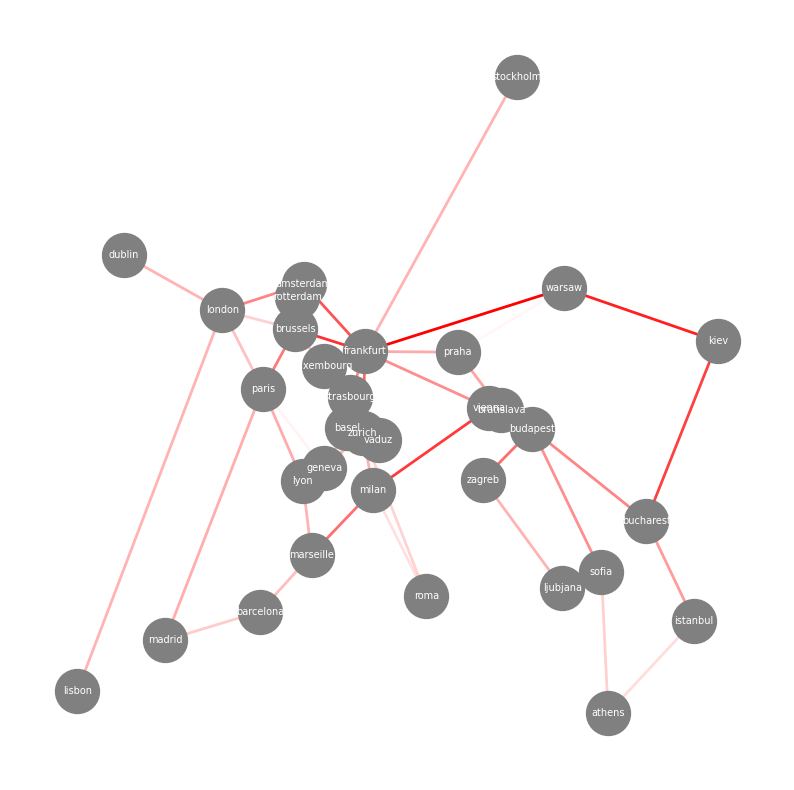

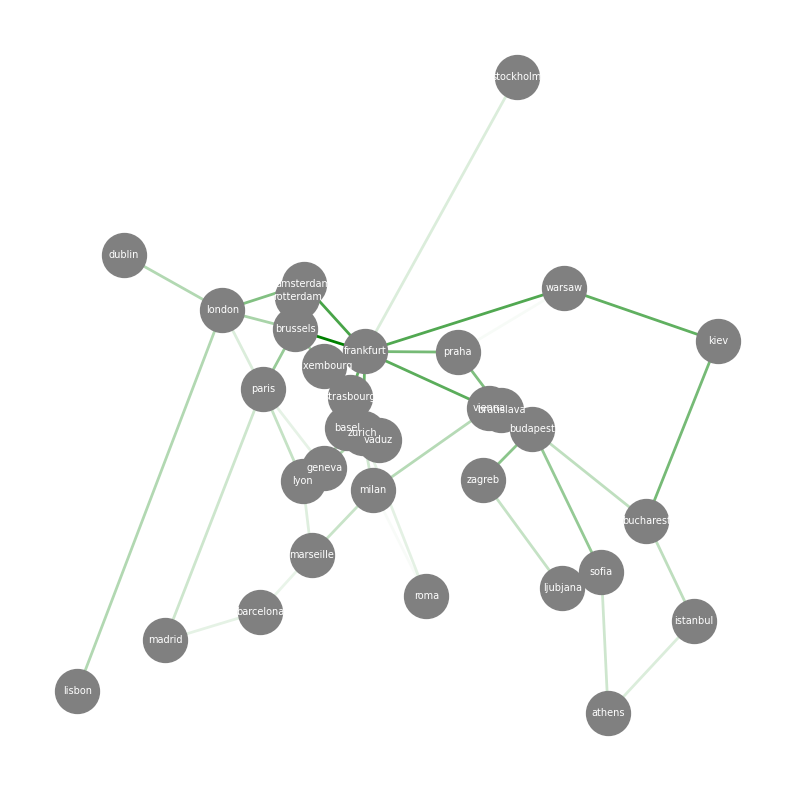

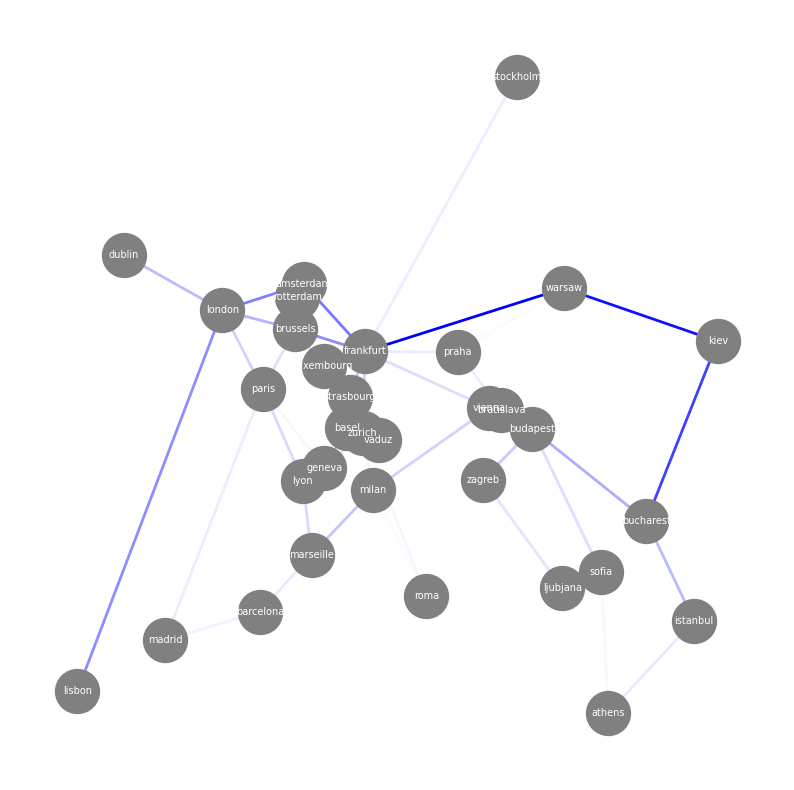

In [ ]:
# Clear all previous weights in the graph
for edge in graph.edges:
    graph.edges[edge[0], edge[1]]["weight"] = 0
    for key in colors.keys():
        graph.edges[edge[0], edge[1]][f"{key}_weight"] = 0

for policy in failures[()]:
    # Get all traces for the policy
    traces = routes[policy].Traces[0]
    count  = routes[policy].TraceCount[0]
    weight = 1
    print(f"Policy {policy} has {routes[policy].TraceCount[0]} traces")

    # Adjust the weight
    if policy.type == "reachability": weight = 1/count
    # Make sure that the number of paths is equal to the number of traces if this is a loadbalancing policy
    if policy.type == "loadbalancing": assert count == policy.num_paths


    # Set the weights
    for trace in traces:
        hops = [hop.node for hop in trace]
        print(f"     Setting weight {weight} along {' -> '.join(hops)}")
        prev_hop = None

        # Make sure that the the waypoint is along the path if we are looking at a waypointing policy
        if policy.type == "waypoint" and policy.waypoints not in hops: continue

        for hop in trace:
            if prev_hop != None:
                # TODO: What about the links that are being travesed more than once? For non-edge-disjoint loadbalancing
                # TODO: Think about wether or not the weighing for the waypointing policies should be different
                graph.edges[prev_hop, hop.node][f"{policy.type}_weight"] += weight
                graph.edges[prev_hop, hop.node]["weight"] += weight
            prev_hop = hop.node

draw_graph(graph, "reachability", colors)
draw_graph(graph, "loadbalancing", colors)
draw_graph(graph, "waypoint", colors)

#with open(f'weight_data/graph-new-sampler.pkl', 'wb') as file:
#    pickle.dump(graph, file)
